In [50]:
import tensorflow as tf
from matplotlib import pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [51]:
def f(x):
    return 2 * tf.sin(x) + x**.8

tf.random.set_seed(1028)
x =tf.sort(tf.random.uniform(shape=(50,), maxval=5))
x_test = tf.range(0, 5, .1)
# y_train表示训练输出
y_train = f(x) + tf.random.normal(shape=x.shape, mean=.0, stddev=.5) 
y_true = f(x_test)

def plot_kernel_reg(y_hat):
    plt.plot(x_test, y_true)
    plt.plot(x_test, y_hat)
    plt.plot(x, y_train, 'o', alpha=0.5);

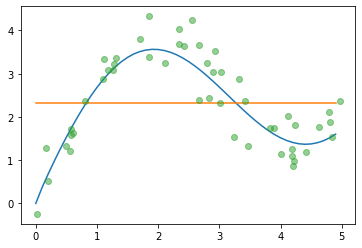

In [52]:
# 经过avgpool的y_train
# avgpool没有考虑x
y_hat = tf.repeat(tf.reduce_mean(y_train), repeats=len(y_train))
plot_kernel_reg(y_hat)

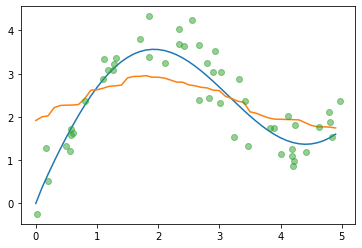

In [53]:
# 高斯kernel
x_repeat = tf.repeat(tf.expand_dims(x, axis=0), repeats=len(y_train), axis=0)
attention_weights = tf.nn.softmax(-((x_repeat - tf.expand_dims(x, axis=1)) ** 2 / 2), axis=1)
y_hat = tf.matmul(attention_weights, tf.expand_dims(y_train, axis=1))
plot_kernel_reg(y_hat)

In [54]:
class NWKernelRegression(tf.keras.layers.Layer):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = tf.Variable(initial_value=tf.random.uniform(shape=(1,)))
    
    def call(self, queries, keys, values, **kwargs):
        queries = tf.repeat(tf.expand_dims(queries, axis=1), repeats=keys.shape[1], axis=1)
        self.attention_weights = tf.nn.softmax(-((queries - keys) * self.w) ** 2 / 2, axis=1)
        return tf.squeeze(tf.matmul(tf.expand_dims(self.attention_weights, axis=1), tf.expand_dims(values, axis=-1)))

In [55]:
tf.cast(1 - tf.eye(50), dtype=tf.bool)

<tf.Tensor: shape=(50, 50), dtype=bool, numpy=
array([[False,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True, False]])>

In [56]:
x_tile = tf.repeat(tf.expand_dims(x, axis=0), repeats=len(x), axis=0)
y_tile = tf.repeat(tf.expand_dims(y_train, axis=0), repeats=len(y_train), axis=0)
keys = tf.reshape(x_tile[tf.cast(1 - tf.eye(len(x)), dtype='bool')], shape=(len(x), -1))
values = tf.reshape(y_tile[tf.cast(1 - tf.eye(len(x)), dtype='bool')], shape=(len(x), -1))

In [57]:
net = NWKernelRegression()
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-1)

for epoch in range(100):
    with tf.GradientTape() as gt:
        y_ = net(x, keys, values)
        loss = loss_fn(y_train, y_)
    grads = gt.gradient(loss, net.trainable_variables)
    optimizer.apply_gradients(zip(grads, net.trainable_variables))
    print(f'loss: {loss: .6f}')

loss:  1.035001
loss:  0.972037
loss:  0.891720
loss:  0.806099
loss:  0.728772
loss:  0.665725
loss:  0.616246
loss:  0.577440
loss:  0.546547
loss:  0.521474
loss:  0.500734
loss:  0.483278
loss:  0.468364
loss:  0.455451
loss:  0.444145
loss:  0.434147
loss:  0.425230
loss:  0.417218
loss:  0.409971
loss:  0.403377
loss:  0.397348
loss:  0.391808
loss:  0.386696
loss:  0.381963
loss:  0.377564
loss:  0.373464
loss:  0.369631
loss:  0.366039
loss:  0.362664
loss:  0.359486
loss:  0.356487
loss:  0.353652
loss:  0.350968
loss:  0.348421
loss:  0.346002
loss:  0.343700
loss:  0.341506
loss:  0.339414
loss:  0.337415
loss:  0.335504
loss:  0.333674
loss:  0.331920
loss:  0.330238
loss:  0.328623
loss:  0.327071
loss:  0.325579
loss:  0.324142
loss:  0.322757
loss:  0.321423
loss:  0.320136
loss:  0.318893
loss:  0.317692
loss:  0.316531
loss:  0.315409
loss:  0.314322
loss:  0.313270
loss:  0.312251
loss:  0.311263
loss:  0.310305
loss:  0.309375
loss:  0.308472
loss:  0.307596
loss:  0

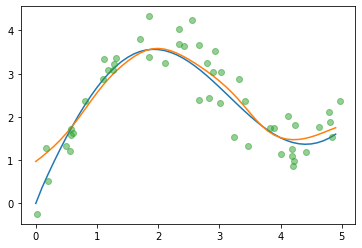

In [58]:
keys = tf.repeat(tf.expand_dims(x, axis=0), repeats=len(x_test), axis=0)
values = tf.repeat(tf.expand_dims(y_train, axis=0), repeats=len(x_test), axis=0)
y_hat = net(x_test, keys, values)
plot_kernel_reg(y_hat)